In [1]:
import pandas as pd
import numpy as np
np.float_ = np.float64
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
import cryptocompare
import requests
import ssl
from typing import Optional
from itertools import product
from tqdm import tqdm
from holidays.holiday_base import HolidayBase
import lightgbm as lgb
from optuna.integration.lightgbm import Dataset
from prophet import Prophet
import re
import prophet
import math
import pickle
import joblib
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from sklearn.model_selection import train_test_split
import optuna
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tools.eval_measures import rmse
#import pmdarima as pm
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.graph_objs as go
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from nixtla import NixtlaClient
import warnings
warnings.filterwarnings("ignore")
import os

In [2]:
end_date = datetime.now().strftime('%Y-%m-%d')
btc_data = cryptocompare.get_historical_price_day('BTC', currency='USD', toTs=datetime.now())
print(btc_data)

[{'time': 1627862400, 'high': 40446.6, 'low': 38698.01, 'open': 39870.76, 'volumefrom': 33109.34, 'volumeto': 1308894644.03, 'close': 39158.53, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1627948800, 'high': 39779.45, 'low': 37679.22, 'open': 39158.53, 'volumefrom': 38225.1, 'volumeto': 1466921591.54, 'close': 38189.3, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1628035200, 'high': 39961.11, 'low': 37526.24, 'open': 38189.3, 'volumefrom': 34035.77, 'volumeto': 1318983897.48, 'close': 39738.56, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1628121600, 'high': 41409.14, 'low': 37330.04, 'open': 39738.56, 'volumefrom': 59748.14, 'volumeto': 2357831521.97, 'close': 40888.18, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 1628208000, 'high': 43363.62, 'low': 39895.05, 'open': 40888.18, 'volumefrom': 48254.57, 'volumeto': 2009167763.65, 'close': 42852.18, 'conversionType': 'direct', 'conversionSymbol': ''}, {'time': 162829440

In [3]:
df = pd.DataFrame(btc_data)
df['time'] = pd.to_datetime(df['time'], unit='s')

In [4]:
df.rename(columns={
    'time': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volumeto': 'Volume'
}, inplace=True)

In [5]:
df['Adj Close'] = df['Close']

In [6]:
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]


It’s important to note that unlike traditional financial assets, Bitcoin trades 24/7. Therefore, the closing price represents the price of Bitcoin at a specific time each day, rather than at the end of a trading day.


In [7]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

FACEBOOK PROPHET

In [8]:
data = df.copy()

# Change date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Take a look at the data
data.head()

Date      Open      High       Low     Close  Adj Close        Volume
0 2021-08-02  39870.76  40446.60  38698.01  39158.53   39158.53  1.308895e+09
1 2021-08-03  39158.53  39779.45  37679.22  38189.30   38189.30  1.466922e+09
2 2021-08-04  38189.30  39961.11  37526.24  39738.56   39738.56  1.318984e+09
3 2021-08-05  39738.56  41409.14  37330.04  40888.18   40888.18  2.357832e+09
4 2021-08-06  40888.18  43363.62  39895.05  42852.18   42852.18  2.009168e+09

In [9]:
# Declare a figure
fig = go.Figure()

# Candlestick chart
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], 
                name = 'Bitcoin Data'))

In [10]:
# Keep only date and close price
df1 = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Rename date to ds and close price to y
df1.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Take a look at the data
df1.head()

ds         y
0 2021-08-02  39158.53
1 2021-08-03  38189.30
2 2021-08-04  39738.56
3 2021-08-05  40888.18
4 2021-08-06  42852.18

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1441 non-null   datetime64[ns]
 1   y       1441 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.6 KB


In [12]:
df1.tail()

ds          y
1436 2025-07-08  108955.05
1437 2025-07-09  111291.70
1438 2025-07-10  116023.34
1439 2025-07-11  117573.92
1440 2025-07-12  117542.59

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1441 non-null   datetime64[ns]
 1   y       1441 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.6 KB


<Axes: xlabel='ds'>

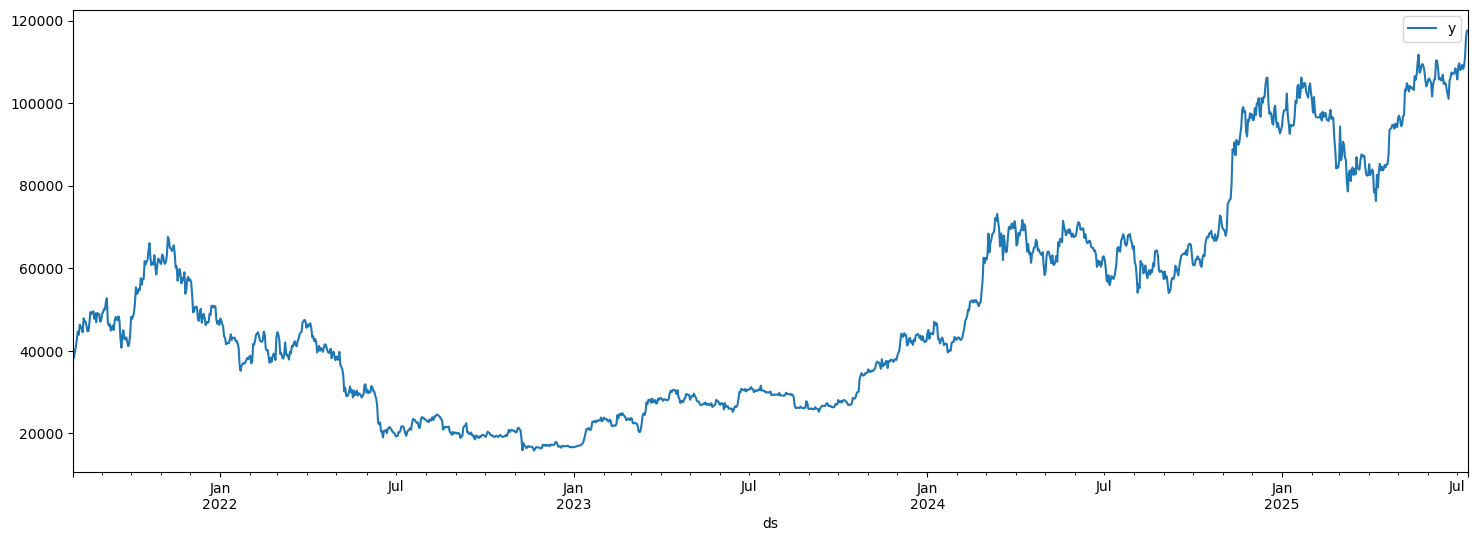

In [14]:
df1.plot(x='ds',y='y',figsize=(18,6))

In [15]:
train = df1.iloc[:-365,:]
train.shape

(1076, 2)

In [16]:
test = df1.iloc[-365:]
test.shape

(365, 2)

In [17]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\rizbo\anaconda3\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\rizbo\AppData\Local\Temp\tmpnxbji7lb\p13lrlgy.json
DEBUG:cmdstanpy:input tempfile: C:\Users\rizbo\AppData\Local\Temp\tmpnxbji7lb\_vmujn4y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\rizbo\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=91739', 'data', 'file=C:\\Users\\rizbo\\AppData\\Local\\Temp\\tmpnxbji7lb\\p13lrlgy.json', 'init=C:\\Users\\rizbo\\AppData\\Local\\Temp\\tmpnxbji7lb\\_vmujn4y.json', 'output', 'file=C:\\Users\\rizbo\\AppData\\Local\\Temp\\tmpnxbji7lb\\prophet_modell27o0658\\prophet_model-20250712200717.csv', 'method=optimize', 'al

In [18]:
forecast.tail()

ds          trend    yhat_lower     yhat_upper   trend_lower  \
1436 2025-07-08  112454.481179  77237.166519  138316.521949  80836.099286   
1437 2025-07-09  112576.353863  77005.933305  138212.341838  80762.089751   
1438 2025-07-10  112698.226548  77236.384354  138794.172997  80788.750440   
1439 2025-07-11  112820.099232  76760.934887  138276.192784  80772.661766   
1440 2025-07-12  112941.971916  77948.214986  140201.154371  80690.913523   

        trend_upper  additive_terms  additive_terms_lower  \
1436  141091.439141    -3230.573464          -3230.573464   
1437  141334.227095    -2974.994541          -2974.994541   
1438  141577.015049    -3005.178945          -3005.178945   
1439  141827.841127    -2925.916627          -2925.916627   
1440  142113.541009    -2728.067142          -2728.067142   

      additive_terms_upper      weekly  weekly_lower  weekly_upper  \
1436          -3230.573464  -19.150175    -19.150175    -19.150175   
1437          -2974.994541  109.937566    109.937566    109.937566   
1438          -3005.178945  -56.761427    -56.761427    -56.761427   
1439          -2925.916627 -121.080526   -121.080526   -121.080526   
1440          -2728.067142  -70.974178    -70.974178    -70.974178   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
1436 -3211.423289  -3211.423289  -3211.423289                   0.0   
1437 -3084.932107  -3084.932107  -3084.932107                   0.0   
1438 -2948.417518  -2948.417518  -2948.417518                   0.0   
1439 -2804.836100  -2804.836100  -2804.836100                   0.0   
1440 -2657.092964  -2657.092964  -2657.092964                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper           yhat  
1436                         0.0                         0.0  109223.907715  
1437                         0.0                         0.0  109601.359322  
1438                         0.0                         0.0  109693.047603  
1439                         0.0                         0.0  109894.182605  
1440                         0.0                         0.0  110213.904774

In [19]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds           yhat    yhat_lower     yhat_upper
1436 2025-07-08  109223.907715  77237.166519  138316.521949
1437 2025-07-09  109601.359322  77005.933305  138212.341838
1438 2025-07-10  109693.047603  77236.384354  138794.172997
1439 2025-07-11  109894.182605  76760.934887  138276.192784
1440 2025-07-12  110213.904774  77948.214986  140201.154371

In [20]:
test.tail()

ds          y
1436 2025-07-08  108955.05
1437 2025-07-09  111291.70
1438 2025-07-10  116023.34
1439 2025-07-11  117573.92
1440 2025-07-12  117542.59

In [21]:
plot_plotly(m, forecast)

In [22]:
plot_components_plotly(m, forecast)

In [23]:
predictions = forecast.iloc[-365:]['yhat']

In [24]:
rmse = rmse(predictions, test['y'])
print("Root Mean Squared Error between actual and predicted values : ", rmse)
print("Mean Value of Test Dataset :", test['y'].mean())

Root Mean Squared Error between actual and predicted values :  13168.942130230851
Mean Value of Test Dataset : 85777.00147945205


In [25]:
max = df1['y'].max()
min = df1['y'].min()

In [26]:
nrmse = rmse/(max-min)
nrmse

0.12934347980602273

In [27]:

#file_path = 'D:\Projects\Bitcoin Price Prediction/prophet_model.pkl'

In [28]:
#pickle.dump(m, open(file_path, "wb"))

81.68% of Accuracy for FB PROPHET Model

ARIMA

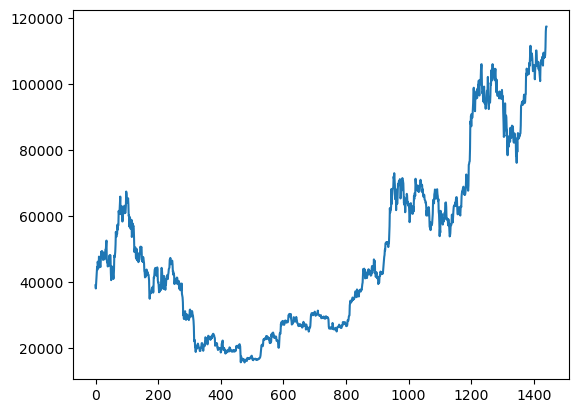

In [29]:
plt.plot(df.index, df['Close'])
plt.show()

In [30]:
to_row = int(len(df)*0.9)

train_data = list(df[0:to_row]['Close'])
test_data = list(df[to_row:]['Close'])

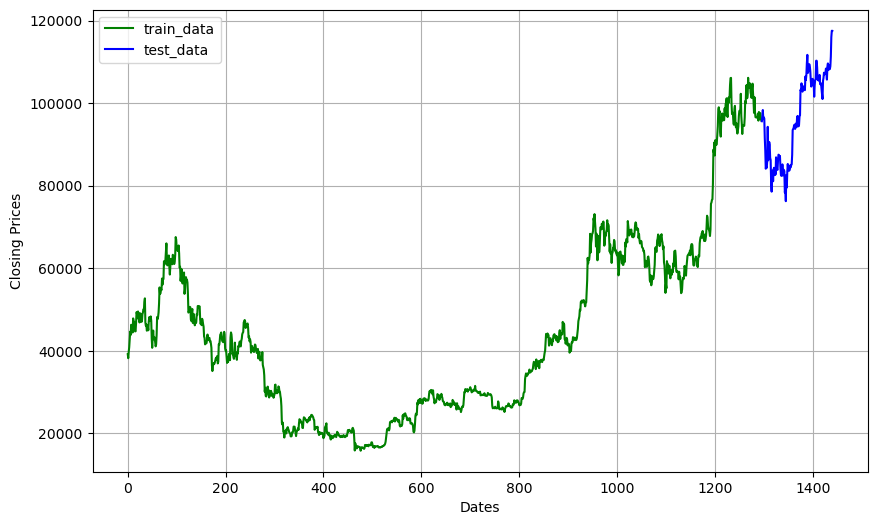

In [31]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel("Dates")
plt.ylabel("Closing Prices")
plt.plot(df[0:to_row]['Close'],'green',label='train_data')
plt.plot(df[to_row:]['Close'],'blue',label = "test_data")
plt.legend()

In [32]:
model_predictions = []
n_test_obser = len(test_data)

model = pm.auto_arima(df['Close'], 
                        m=12, seasonal=True,
                      start_p=0, start_q=0, max_order=4, test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

In [33]:
#Best model:  ARIMA(2,1,3)(2,0,2)[12]

for i in range(n_test_obser):
    model = ARIMA(train_data, order = (2,1,3))
    model_fit=model.fit()
    output = model_fit.forecast()
    yhat = [output[0]]
    model_predictions.append(yhat)
    actual_test_value = test_data[i]
    train_data.append(actual_test_value)

In [34]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1440
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -12563.659
Date:                Sat, 12 Jul 2025   AIC                          25139.319
Time:                        20:12:04   BIC                          25170.949
Sample:                             0   HQIC                         25151.127
                               - 1440                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0194      0.048      0.405      0.685      -0.075       0.113
ar.L2          0.9080      0.049     18.472      0.000       0.812       1.004
ma.L1         -0.0624      0.051     -1.219      0.223      -0.163       0.038
ma.L2         -0.9207      0.049    -18.620      0.000      -1.018      -0.824
ma.L3          0.0707      0.018      3.837      0.000       0.035       0.107
sigma2      2.255e+06   4.75e+04     47.486      0.000    2.16e+06    2.35e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1161.94
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

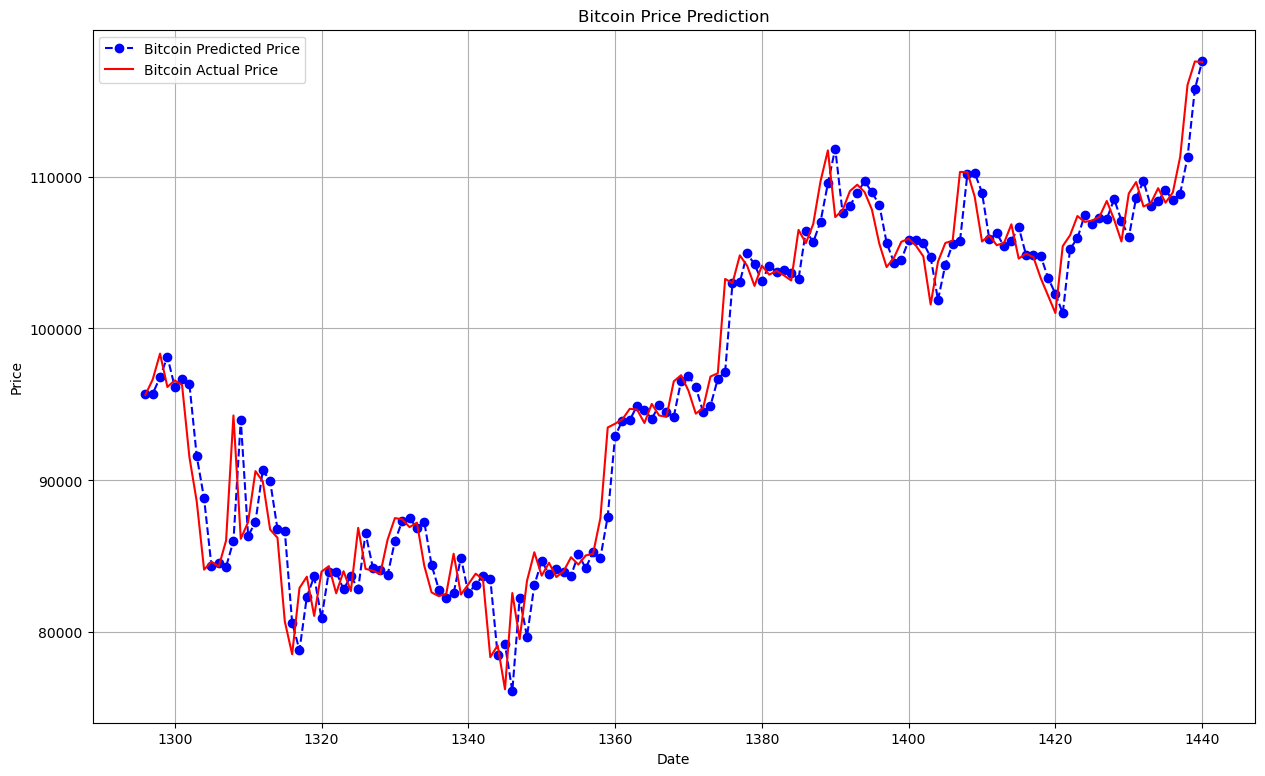

In [35]:
plt.figure(figsize=(15,9))
plt.grid(True)
date_range = df[to_row:].index
plt.plot(date_range, model_predictions, color = "blue" , marker = 'o', linestyle = 'dashed', label = "Bitcoin Predicted Price")
plt.plot(date_range, test_data, color = 'red', label = 'Bitcoin Actual Price')
plt.title("Bitcoin Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [36]:
mape = np.mean(np.abs(np.array(model_predictions[:-1]) - np.array(test_data))/np.abs(test_data))
print("MAPE: ", str(mape))

MAPE:  0.12620489117812567


This is generally considered excellent accuracy in time series forecasting as it means that, on average, your model's predictions are within about 7.94% of the actual values.

In [37]:
#model_path = os.path.join('D:\Projects\Bitcoin Price Prediction', 'arima_model.pkl')

In [38]:
#joblib.dump(model_fit,model_path)

69% of Accuracy for ARIMA Model

LSTM

In [39]:
df2 = df.reset_index()['Close']
df2

0        39158.53
1        38189.30
2        39738.56
3        40888.18
4        42852.18
          ...    
1436    108955.05
1437    111291.70
1438    116023.34
1439    117573.92
1440    117542.59
Name: Close, Length: 1441, dtype: float64

In [40]:
df2.shape

(1441,)

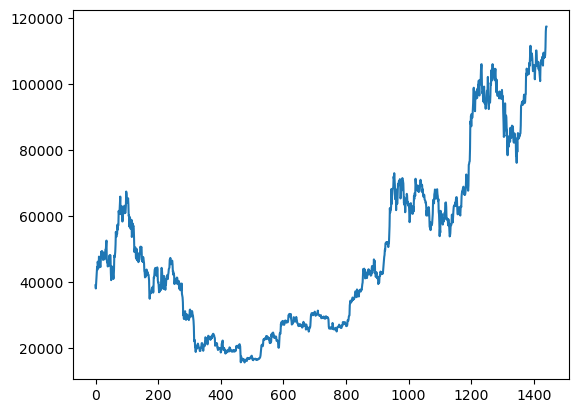

In [41]:
plt.plot(df2)

In [42]:
#LSTM are sensitive to the scale of the data, so we apply MinMax Scaler
scaler = MinMaxScaler(feature_range=(0,1))
df3 = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [43]:
df3.shape

(1441, 1)

In [44]:
#Spliiting dataset into train(70% of data) and test split(30% of data)
training_size = int(len(df3)*0.65)
test_size = len(df3) - training_size
train_data,test_data = df3[0:training_size,:],df3[training_size:len(df3),:1]

In [45]:
training_size,test_size

(936, 505)

In [46]:
#Converting an array of values into a dataset matrix
#Timesteps = How many number of previous days data we should consider to make prediction for the next data 
def create_dataset(dataset,time_steps=1):
    dataX,dataY = [] , []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [47]:
time_step = 100 #Timestamp
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [48]:
print(X_train)

[[0.22981517 0.22029553 0.23551215 ... 0.46695657 0.50866371 0.50267336]
 [0.22029553 0.23551215 0.24680355 ... 0.50866371 0.50267336 0.48290019]
 [0.23551215 0.24680355 0.26609368 ... 0.50267336 0.48290019 0.48186635]
 ...
 [0.20939779 0.20353168 0.19438459 ... 0.35268907 0.35731075 0.35379344]
 [0.20353168 0.19438459 0.21729879 ... 0.35731075 0.35379344 0.35859014]
 [0.19438459 0.21729879 0.20038781 ... 0.35379344 0.35859014 0.35451181]]


In [49]:
print(X_test.shape), print(ytest.shape)

(404, 100)
(404,)


(None, None)

In [50]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [51]:
model = Sequential() #One LSTM after the another LSTM is Stacked LSTM
model.add(LSTM(50,return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ lstm (LSTM)                   │ (None, 100, 50)       │       10,400 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm_1 (LSTM)                 │ (None, 100, 50)       │       20,200 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm_2 (LSTM)                 │ (None, 50)            │       20,200 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 1)             │           51 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model.fit(X_train, y_train, validation_data = (X_test,ytest), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - loss: 0.0130 - val_loss: 0.0677
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.0020 - val_loss: 0.0121
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 9.1948e-04 - val_loss: 0.0092
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - loss: 8.0943e-04 - val_loss: 0.0142
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 7.1143e-04 - val_loss: 0.0094
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 6.5083e-04 - val_loss: 0.0077
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 6.5059e-04 - val_loss: 0.0139
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 6.2373e-04 - val_loss: 0.0157
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 5.3224e-04 - val_loss: 0.0067
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 6.8762e-04 - val_loss: 0.0077
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 6.2791e-04 - val_loss: 0.0163
Epoc

In [54]:
#model.save("D:\\Projects\\Bitcoin Price Prediction\\lstm_model.h5")

In [55]:
#Prediction and checking performance Metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [56]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [57]:
#Train Data RMSE
math.sqrt(mean_squared_error(y_train,train_predict))

32921.5115092238

In [58]:
#Test Data RMSE
math.sqrt(mean_squared_error(ytest, test_predict))

81746.7195411495

In [59]:
mape = np.mean(np.abs(np.array(ytest[:-1]) - np.array(test_predict))/np.abs(test_predict))
print("MAPE: ", str(mape))

MAPE:  0.9999913771388493


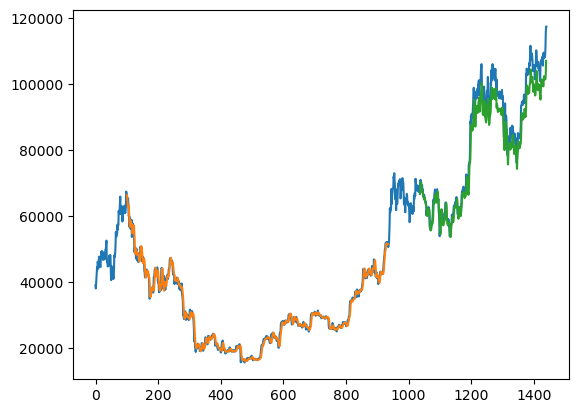

In [60]:
#PLotting : shift train prediction for plotting
look_back = 100
trainPredictPLot = np.empty_like(df3)
trainPredictPLot[:,:] = np.nan
trainPredictPLot[look_back:len(train_predict)+look_back,:] = train_predict

#shift test prediction for plotting
testPredictPlot = np.empty_like(df3)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df3)-1,:] = test_predict

#PLot baseline and predictions
plt.plot(scaler.inverse_transform(df3))
plt.plot(trainPredictPLot)
plt.plot(testPredictPlot)
plt.show()

In [61]:
len(test_data)

505

In [62]:
x_input = test_data[405:].reshape(1,-1)
x_input.shape

(1, 100)

In [63]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [64]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.92485803]
101
1 day input [0.6653639  0.61490115 0.62253755 0.59417242 0.65636373 0.62658317
 0.6642111  0.68273631 0.66759886 0.67589666 0.66668788 0.67053049
 0.67950786 0.67475939 0.68066802 0.68170521 0.70477115 0.76338535
 0.76580084 0.7686811  0.775446   0.77497868 0.76627435 0.77862652
 0.77115307 0.77028855 0.79320461 0.79718993 0.78715268 0.772331
 0.776003   0.79631382 0.79843927 0.85940089 0.85668318 0.87467466
 0.86789699 0.85491662 0.86802045 0.86219776 0.86459312 0.86176403
 0.85842185 0.89112176 0.88257252 0.89492537 0.9226621  0.94252435
 0.89941425 0.9038002  0.91619519 0.92031841 0.91555196 0.90420928
 0.88226401 0.86706459 0.87310876 0.88339755 0.88542675 0.8808976
 0.87400599 0.84291598 0.87053436 0.88264166 0.88415472 0.92857741
 0.92851927 0.91261355 0.8836318  0.88751183 0.88122633 0.88264166
 0.89472412 0.87255904 0.87579229 0.87355144 0.85993431 0.84866245
 0.83736476 0.88066256 0.88763136 0.90007202 0.89626399 0.89717733
 0.89954714 0.90981521 0.89781241 0.

In [65]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

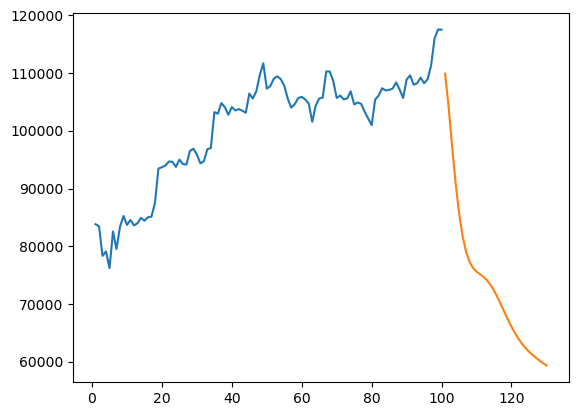

In [66]:
plt.plot(day_new,scaler.inverse_transform(df3[1341:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

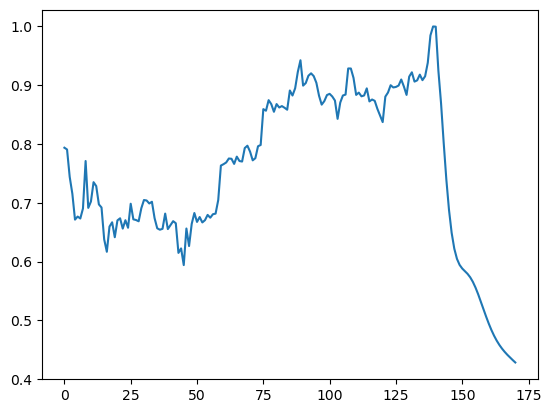

In [67]:
df5=df3.tolist()
df5.extend(lst_output)
plt.plot(df5[1300:])

In [68]:
df5=scaler.inverse_transform(df5).tolist()

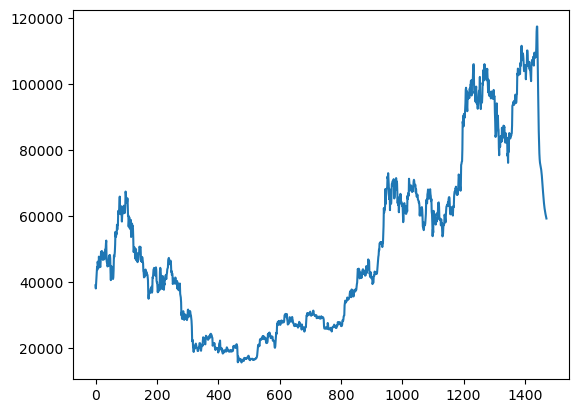

In [69]:
plt.plot(df5)

MLFORECAST

In [70]:
df6 = df[['Date','Close']]

In [71]:
train_size = int(len(df6) * 0.8)
train, test = df6.iloc[:train_size], df6.iloc[train_size:]

print(f'Train set size: {len(train)}')
print(f'Test set size: {len(test)}')

Train set size: 1152
Test set size: 289


In [72]:
train_ = pd.DataFrame({'unique_id':[1]*len(train),'ds': train["Date"], "y":train["Close"]})
test_ = pd.DataFrame({'unique_id':[1]*len(test),'ds': test["Date"], "y":test["Close"]})

In [73]:
# Define metrics functions
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))) * 100

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'LGBMRegressor': lgb.LGBMRegressor(verbosity=-1),
    'XGBRegressor': xgb.XGBRegressor(),
    'RandomForestRegressor': RandomForestRegressor(random_state=0),
}
@njit
def rolling_mean_7(x):
    return rolling_mean(x, window_size=7)
@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)

# Initialize MLForecast
fcst = MLForecast(
    models=list(models.values()),
    freq='W',
    lags=[7, 14, 28],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_7, rolling_mean_14],
        14: [rolling_mean_7, rolling_mean_14]
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],
    target_transforms=[Differences([7])]
)

# Fit model
fcst.fit(train_)

# Predict
all_predictions = fcst.predict(len(test_))
all_predictions.rename(columns={'ds': 'Date'}, inplace=True)

# Split predictions by model
model_predictions = {model_name: all_predictions[f'{model_name}'] for model_name in models.keys()}

# Create a dictionary to hold metrics for each model
model_metrics = {}

# Evaluate each model
for model_name, y_pred in model_predictions.items():
    mse = mean_squared_error(test_['y'], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_['y'], y_pred)
    
    # Store metrics
    model_metrics[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(model_metrics).T
metrics_df = metrics_df.round(4)  # Round to 4 decimal places for readability

# Display the metrics table
print(metrics_df)

  File "C:\Users\rizbo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\rizbo\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rizbo\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\rizbo\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


                                MSE        RMSE         MAE
LinearRegression       5.414148e+08  23268.3208  19623.4067
LGBMRegressor          6.722573e+08  25927.9259  23044.2340
XGBRegressor           7.279587e+08  26980.7095  23685.5871
RandomForestRegressor  5.786789e+08  24055.7462  21451.1490


In [74]:
# Save the XGBRegressor model
#xgb_model = models['XGBRegressor']

In [75]:
#model_path2 = os.path.join('D:\Projects\Bitcoin Price Prediction', 'xgb_model.pkl')

In [76]:
#with open(model_path2, 'wb') as file:
    #pickle.dump(xgb_model, file)

TIMEGPT

In [77]:
# 1. Instantiate the NixtlaClient
nixtla_client = NixtlaClient(api_key = 'nixtla-tok-xmAyKHqhIBdxxbi4cHkXXu2QxqAIhzfmykdQw4SkorJjqlO2ZjI5JuDQ0yYiCZplmhaDM0DPbnDbhpMs')

In [78]:
df6.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

if we set the add_history argument of the forecast method to True, TimeGPT will generate predictions for the historical observations too. This can be useful for assessing the model’s performance on the training data.

level: (list) The confidence level for the prediction intervals. Given the inherent volatility of Bitcoin, we will use multiple confidence levels.

In [79]:
level = [50,80,90] # confidence levels 
# h = 30 is the forecast for the next 10 days
fcst = nixtla_client.forecast(df6, h=10, level=level, add_history = True)
fcst.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Calling Historical Forecast Endpoint...


ds    TimeGPT  TimeGPT-hi-50  TimeGPT-hi-80  TimeGPT-hi-90  \
0 2021-09-05  49030.277      51026.883      52823.890      53899.324   
1 2021-09-06  48509.195      50505.800      52302.810      53378.242   
2 2021-09-07  48196.550      50193.156      51990.164      53065.598   
3 2021-09-08  48385.824      50382.430      52179.438      53254.870   
4 2021-09-09  48724.453      50721.060      52518.066      53593.500   

   TimeGPT-lo-50  TimeGPT-lo-80  TimeGPT-lo-90  
0      47033.670      45236.664      44161.230  
1      46512.590      44715.582      43640.150  
2      46199.945      44402.938      43327.504  
3      46389.220      44592.210      43516.777  
4      46727.848      44930.840      43855.406

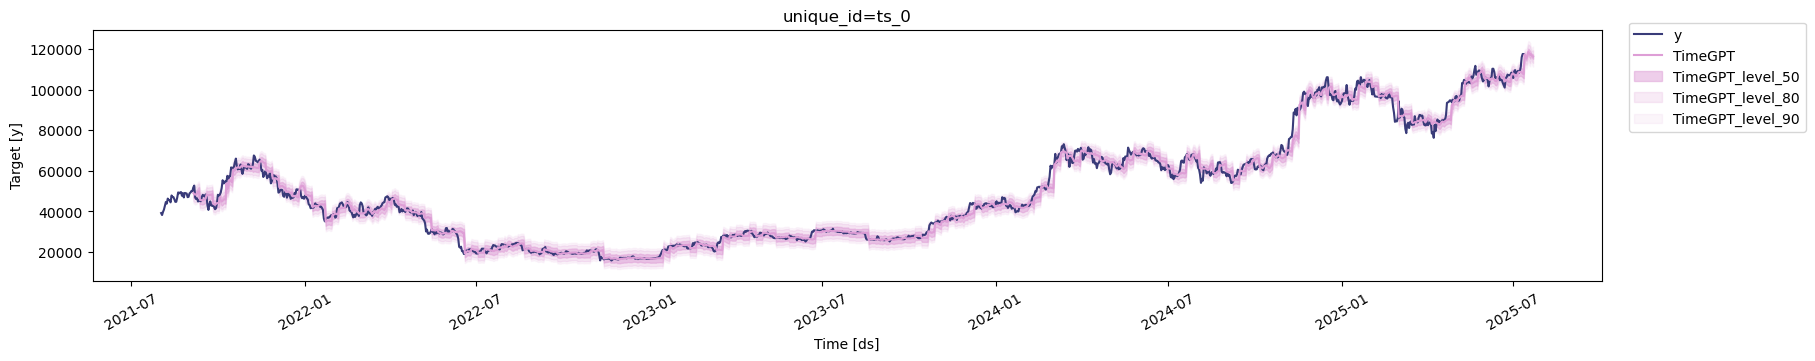

In [80]:
nixtla_client.plot(df6, fcst, level=level)

Given the volatility of the price of Bitcoin, it can be useful to try to identify anomalies in the data. TimeGPT can be used for this by calling the detect_anomalies method from the NixtlaClient class. This method evaluates each observation against its context within the series, using statistical measures to determine its likelihood of being an anomaly. By default, it identifies anomalies based on a 99 percent prediction interval. To change this, you can specify the level argument.

In [81]:
anomalies_df = nixtla_client.detect_anomalies(df6)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Anomaly Detector Endpoint...


In [82]:
anomalies_df

ds          y     TimeGPT  TimeGPT-hi-99  TimeGPT-lo-99  anomaly
0    2021-09-05   51784.16   49030.277      56655.170      41405.383    False
1    2021-09-06   52693.32   48509.195      56134.090      40884.300    False
2    2021-09-07   46856.31   48196.550      55821.445      40571.656    False
3    2021-09-08   46073.45   48385.824      56010.720      40760.930    False
4    2021-09-09   46392.85   48724.453      56349.348      41099.560    False
...         ...        ...         ...            ...            ...      ...
1402 2025-07-08  108955.05  108743.100     116367.990     101118.210    False
1403 2025-07-09  111291.70  108767.555     116392.445     101142.664    False
1404 2025-07-10  116023.34  108564.810     116189.700     100939.920    False
1405 2025-07-11  117573.92  108002.930     115627.820     100378.040     True
1406 2025-07-12  117542.59  107626.280     115251.170     100001.390     True

[1407 rows x 6 columns]

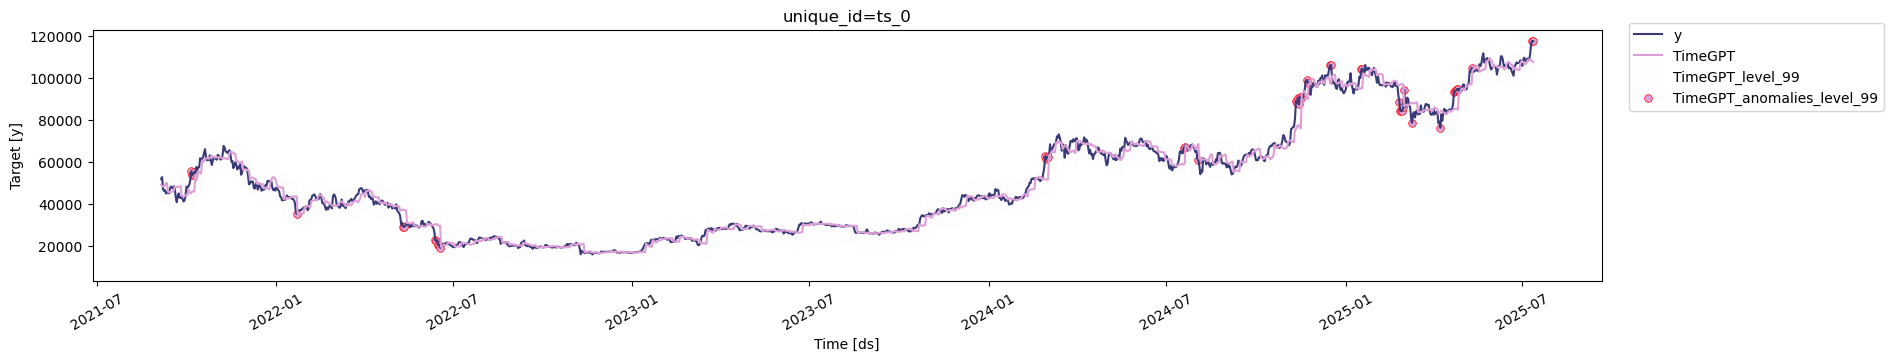

In [83]:
nixtla_client.plot(df6, anomalies_df, plot_anomalies=True)

In [84]:
df6['y'].shape

(1441,)

In [85]:
fcst['TimeGPT']

0        49030.277
1        48509.195
2        48196.550
3        48385.824
4        48724.453
           ...    
1412    117824.530
1413    117151.020
1414    117442.420
1415    116553.320
1416    116282.984
Name: TimeGPT, Length: 1417, dtype: float64

In [86]:
# Define evaluation metric functions
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))) * 100

# Ensure your actual column name is used
y_true = df6['y'][:1417]  # Replace with the actual column name

# Get TimeGPT predictions
y_pred = fcst['TimeGPT']

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
mdape = median_absolute_percentage_error(y_true, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

# Store metrics
timegpt_metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape,
    'MDAPE': mdape,
    'SMAPE': smape
}

# Print metrics
print(f'Metrics for TimeGPT:')
for metric_name, value in timegpt_metrics.items():
    print(f'  {metric_name}: {value}')


Metrics for TimeGPT:
  MSE: 62618827.36865875
  RMSE: 7913.205884384581
  MAE: 5560.077047282993
  MAPE: 12.141910090439158
  MDAPE: 9.541264369050568
  SMAPE: 11.72325109480451
